In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

The ""IGNORE" part was mainly for splitting the labels of the images and storing them to prepare for training our model. The [UTK Face Cropped](https://www.kaggle.com/datasets/abhikjha/utk-face-cropped/data) dataset, contains images as the following format:

[age]_[gender]_[race]_[date&time].jpg

After the creation of npz format files, we do not run these blocks.

# **Creation of Labels**

In [ ]:
path = "/content/drive/MyDrive/R&D Project/gender_classification_project/utkcropped"
files = os.listdir(path)

In [ ]:
images = []
ages = []
genders = []
eths = []

In [ ]:
for i in files:
    parts = i.split('.')
    extension_removed = parts[0]
    new_parts = extension_removed.split('_')

    ages.append(int(new_parts[0]))
    genders.append(int(new_parts[1]))
    eths.append(int(new_parts[2]))

    # 0 -> greyscale
    img = cv2.imread(os.path.join(path, i), 0)
    img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_AREA)
    img = img.reshape((img.shape[0], img.shape[1], 1))
    images.append(img)


Age:  60
Gender:  0
Ethnicity:  1


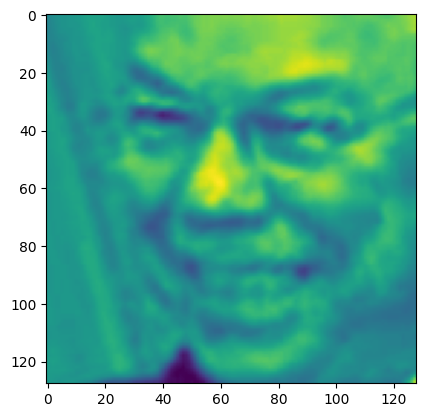

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[2325],)
print("Gender: ", genders[2325])
print("Age: ", ages[2325])
print("Ethnicity: ", eths[2325])

# **Dataset Loading & Preprocessing**

In [ ]:
ages_numpy = np.array(ages)
genders_numpy = np.array(genders)
eths_numpy = np.array(eths)
images_numpy = np.array(images)

In [ ]:
np.savez('/content/drive/MyDrive/R&D Project/gender_classification_project/dataset.npz', ages=ages_numpy, genders=genders_numpy, eths=eths_numpy, images=images_numpy)

Getting our dataset from the npz format.

In [ ]:
dataset = np.load('/content/drive/MyDrive/R&D Project/gender_classification_project/dataset.npz')
ages_numpy = dataset['ages']
genders_numpy = dataset['genders']
eths_numpy = dataset['eths']
images_numpy = dataset['images']

Shuffling (the data is saved in a sequential way) and reducing the sample size

In [ ]:
index = np.random.permutation(len(images_numpy))
genders_numpy = genders_numpy[index]
ages_numpy = ages_numpy[index]
images_numpy = images_numpy[index]
eths_numpy = eths_numpy[index]

In [ ]:
sample_size = 2000
genders_numpy = genders_numpy[:sample_size]
ages_numpy = ages_numpy[:sample_size]
images_numpy = images_numpy[:sample_size]
eths_numpy = eths_numpy[:sample_size]

In [ ]:
images_numpy = images_numpy / 255
images_rgb_format = np.repeat(images_numpy, 3, axis = -1)

In [ ]:
images_rgb_format.shape

(2000, 128, 128, 3)

# **Categorization**

In [ ]:
def age_categories(ages):
  if ages <= 14:
    return 'Children'
  elif ages >= 15 and ages <= 24:
    return 'Youth'
  elif ages >= 25 and ages <= 35:
    return 'Young Adults'
  elif ages >= 36 and ages <= 50:
    return 'Mid Adults'
  elif ages >= 51 and ages <= 64:
    return 'Old Adults'
  else:
    return 'Seniors'

def eth_categories(eth):
  if eth == 0:
    return 'White'
  elif eth == 1:
    return 'Black'
  elif eth == 2:
    return 'Asian'
  else:
    return 'Other'


In [ ]:
def create_labels(age, gender, eth):
  category_age = age_categories(age)

  if gender == 0:
    category_gender = 'male'
  else:
    category_gender = 'female'

  category_eth = eth_categories(eth)
  return f"{category_age}_{category_gender}_{category_eth}"

In [ ]:
combined_label = np.array([create_labels(age, gender, eth) for age, gender, eth in zip(ages_numpy,genders_numpy,eths_numpy)])

# **"gender_classification_model.h5" Creation & Training**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test, label_train, label_test = train_test_split(images_rgb_format, genders_numpy, combined_label, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid, label_train, label_valid = train_test_split(X_train, Y_train, label_train, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, DepthwiseConv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

**Making our gender categorical**

In [ ]:
Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(Y_test)
Y_valid_cat = to_categorical(Y_valid)

Saving our splitted dataset as npz format.

In [ ]:
np.savez('/content/drive/MyDrive/R&D Project/gender_classification_project/splitted_data.npz',X_train = X_train, X_test = X_test, Y_train = Y_train_cat, Y_test = Y_test_cat, label_train = label_train, label_test = label_test, X_valid = X_valid, Y_valid = Y_valid_cat, label_valid = label_valid)

Getting our splitted dataset from npz format.

In [18]:
split_data = np.load('/content/drive/MyDrive/R&D Project/gender_classification_project/splitted_data.npz')
X_train = split_data['X_train']
X_test = split_data['X_test']
X_valid = split_data['X_valid']
Y_train = split_data['Y_train']
Y_test = split_data['Y_test']
Y_valid = split_data['Y_valid']
label_train = split_data['label_train']
label_test = split_data['label_test']
label_valid = split_data['label_valid']

In [19]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))

In [20]:
for l in base_model.layers:
  l.trainable = False

In [21]:
# removing the layer from base model
base_model.layers.pop()
base_model.summary()
model4 = Model(base_model.input, base_model.layers[-1].output)
model4.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 63, 63, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_98 (Ba  (None, 63, 63, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_98 (Activation)  (None, 63, 63, 32)           0         ['batch_normalizati

Defining the custom CNN Architecture that will be used after Feature Extraction with InceptionV3 (Transfer Learning)

In [22]:
def custom_CNN(input_model):
  l = DepthwiseConv2D((3,3),padding='same',activation='relu')(input_model.output)
  l = BatchNormalization()(l)
  l = Activation('relu')(l)
  l = DepthwiseConv2D((3,3),padding='same',activation='relu')(l)
  l = BatchNormalization()(l)
  l = Activation('relu')(l)
  l = DepthwiseConv2D((3,3),padding='same',activation='relu')(l)
  l = GlobalAveragePooling2D()(l)
  l = Flatten()(l)
  l = Dropout(0.2)(l)
  l = Dense(128, activation = 'relu')(l)
  output = Dense(2, activation = 'softmax')(l)
  model = Model(inputs = input_model.input, outputs = output)
  return model

# shape_of_input = (128, 128, 3)
custom_model = custom_CNN(input_model=model4)

In [23]:
custom_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 63, 63, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_98 (Ba  (None, 63, 63, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_98 (Activation)  (None, 63, 63, 32)           0         ['batch_normalization_98

In [24]:
custom_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(Y_train.shape)

(1280, 128, 128, 3)
(400, 128, 128, 3)
(320, 128, 128, 3)
(1280, 2)


In [26]:
datagen_train = ImageDataGenerator(
    shear_range=0.3,
    rotation_range=15,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True
)

In [27]:
datagen_valid = ImageDataGenerator(vertical_flip=True, horizontal_flip=True)

In [28]:
checkpoint = '/content/drive/MyDrive/R&D Project/gender_classification_project/gender_classification_model.h5'
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    mode = 'max'
)

In [30]:
model_history = custom_model.fit(
    datagen_train.flow(X_train, y=Y_train, batch_size=16),
    epochs = 100,
    validation_data = datagen_valid.flow(X_valid, y=Y_valid),
    callbacks = [checkpoint_callback]
)

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.6891
Epoch 1: val_accuracy did not improve from 0.52188
80/80 [==============================] - 52s 655ms/step - loss: 0.5940 - accuracy: 0.6891 - val_loss: 0.6792 - val_accuracy: 0.5188
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.6953
Epoch 2: val_accuracy improved from 0.52188 to 0.59688, saving model to /content/drive/MyDrive/R&D Project/gender_classification_project/gender_classification_model.h5
80/80 [==============================] - 54s 680ms/step - loss: 0.5778 - accuracy: 0.6953 - val_loss: 0.6649 - val_accuracy: 0.5969
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.7172
Epoch 3: val_accuracy improved from 0.59688 to 0.68125, saving model to /content/drive/MyDrive/R&D Project/gender_classification_project/gender_classification_model.h5
80/80 [==============================] - 54s 672ms/step - loss: 

In [31]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

In [32]:
model = load_model('/content/drive/MyDrive/R&D Project/gender_classification_project/gender_classification_model.h5')
pred = model.predict(X_test)
pred_class = np.argmax(pred, axis = 1)

13/13 [==============================] - 13s 736ms/step


In [33]:
actual_labels = np.argmax(Y_test, axis = 1)

In [34]:
print(classification_report(actual_labels, pred_class))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       214
           1       0.78      0.78      0.78       186

    accuracy                           0.80       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.80      0.80      0.80       400



In [35]:
scores = model.evaluate(X_test, Y_test)
print("Accuracy: ", scores[1])

13/13 [==============================] - 13s 831ms/step - loss: 0.4615 - accuracy: 0.7950
Accuracy:  0.7950000166893005


As we can see from the accuracy, this model is not ready for efficient classification. It is important to consider that the model is trained on 2000 images for testing out. This can be increased to make it closer to a real-life application.

Also another thing to mention is that the InceptionV3 is trained on the shape of (299, 299, 3) images. Since we are sending less than what it is trained for, this might be one of the reasons the accuracy is not sufficient.

What can be added after this is that the accuracy of our model on different Ethnic groups and Ages. Although I have categorization, I was not able to modify the code to show accurate results before the deadline.

# **model.h5**

This is the first attempt of creating a model that mostly relies on InceptionV3.
Although the structure was simple, there were problems with the creation of the custom CNN that is added on top of the InceptionV3 layers. Since it was trained only for 10 epochs, the testing part is not done thoroughly.
The results of this attempt can be seen in my report.

In [ ]:
# model.h5
# def custom_CNN(shape_of_input):

#   input = Input(shape = shape_of_input)
#   l = GlobalAveragePooling2D()(input)
#   l = Dense(128, activation='relu')(l)
#   output = Dense(2, activation = 'softmax')(l)
#   model = Model(inputs = input, outputs = output)
#   return model

# shape_of_input = (128, 128, 3)
# custom_model = custom_CNN(shape_of_input)

In [ ]:
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))
# for l in base_model.layers:
#   l.trainable = False
# new_output = custom_model((128,128,3))
# merged_model = Model(inputs=base_model.input, outputs=new_output)
# merged_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# datagen_train = ImageDataGenerator(
#     shear_range=0.3,
#     rotation_range=15,
#     zoom_range=0.3,
#     vertical_flip=True,
#     horizontal_flip=True
# )
# datagen_valid = ImageDataGenerator(vertical_flip=True, horizontal_flip=True)
# checkpoint = '/content/drive/MyDrive/R&D Project/gender_classification_project/model.h5'
# checkpoint_callback = ModelCheckpoint(
#     filepath = checkpoint,
#     monitor = 'val_accuracy',
#     verbose = 1,
#     save_best_only = True,
#     mode = 'max'
# )
# model_history = merged_model.fit(
#     datagen_train.flow(X_train, y=Y_train, batch_size=32),
#     epochs = 10,
#     validation_data = datagen_valid.flow(X_valid, y=Y_valid),
#     callbacks = [checkpoint_callback]
# )

# from sklearn.metrics import classification_report
# from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/R&D Project/gender_classification_project/model.h5')
# pred = model.predict(datagen_valid.flow(X_test))
# pred_class = np.argmax(pred, axis = 1)

# actual_labels = np.argmax(Y_test, axis = 1)

# print(classification_report(actual_labels, pred_class))